# Techniques of High Performance Computing - Assignment 4

**Name: John Duffy**

**Student Number: 19154676**

# In the Moment of Heat

Reference: The SIAM 100-Digit Challenge: A Study in High-Accuracy Numerical Computing, Folkmar Bourneman et al

*A square plate [-1, 1] x [-1, 1] is at temperature u = 0. At time t = 0 the temperature is increased to u = 5 along one of the four sides while being held at u = 0 along the other three sides, and heat flows into the plate according to u'(t) = \delta u. When does the temperature reach u = 1 at the centre of the palte?*

To twelve digits the wanted solution is t* = 0.424011387033.

The assignemnt is achieve as many reliable digits of precision as possible. 

## General Programming Considerations

Irrespective of the method used it would be easy to throw away digits of precision through sloppy programming practices. So, these general programming practices will be used throughout.

* Addition and multiplication make numbers bigger and generally don't lose precision.

* Subtraction and division make numbers smaller and can be a source of a loss of precision.

* Given the above, make a number bigger before making it smaller in an expression.

* Use integer operations were possible.

* Minimise floating point operations.

* Do floating point operations after integer operations.

The plate domain of [-1, 1] x [-1, 1] is translated to [0, 2] x [0, 2] for easier manipulation of array indexes and reduce problem complexity.

To following common parameter names are used throughout:

* N - the number of space grid points, common to the x and y axes.

* M - the number of time points.

* h - the distance between space grid points, (N - 1) / 2.

* k - the distance between time points, (M - 1) / 2.

* C - the Courant number, k / h^2.

* t* - The time the centre of the plate reaches 1.0

M and N are selected to be odd numbers to ensure an even number of space and time intervals, and so that the temperature of the centre of the plate is easily accessed as the array index, u[(N - 1) // 2, (N - 1) // 2].

# Explicit Finite Differences Approach

## Discussion

Heat flows into the plate according to u'(t) = \delta u.

At time t = 0 we know the temperature of all of the points on the plate. So, if we can calculate \delta from this information we can determine u'(t). Having determined u'(t), we can then estimate u(t + 1). And repeat this process for u(t + 2) etc, counting the number of iterations, until the centre of the plate reaches 1. From the number of iterations, and the known time interval between iterations, the required value of T can be estimated.

Using the second order Central Differences method in space, and the first order Forward Euler Method in time, for smooth solutions u this discretisation is known to be of second order O(2), as per the Reference. This is something we will check from our data.  

### Calculating \delta

To calculate \delta we will use the 5-point stencil scheme:

    \delta = u(x - h) + u(x + h) + u(y - h) + u(y + h) - 4 * u(x, y))
    
The origin of this scheme is the Taylor expansions of u(x + h) and u(x - h):

    u(x + h) = u(x) + h * u'(x) + h^2 * u''(x) / 2! + h^3 * u'''(x) / 3! + h^4 u''''(x) / 4! + ...

    u(x - h) = u(x) - h * u'(x) + h^2 * u''(x) / 2! - h^3 * u'''(x) / 3! + h^4 u''''(x) / 4! + ...
    
Adding the above, and dropping O(h^4) terms, yields the Central Differences Method:

    u(x + h) + u(x - h) = 2 * u(x) + h^2 * u''(x)
    
    u''(x) = h^-2 * (u(x + h) + u(x - h) - 2 * u(x))
    
Doing the same for the Taylor expansion of y, and summing u''(x) and u''(y), yields the 5-point stencil:

    u''(x) + u''(y) = h^-2 * (u(x + h) + u(x - h) + u(y + h) + u(y - h) - 4 * u(x, y))
    
And since \delta = u''(x) + u''(y) we have a means of determining \delta from the grid values.

And hence u'(t).

### Estimating u(t + 1)

To estimate u(t + 1) we can use the Forward Euler Method:

    u(t + 1) = u(t) + k * u'(t)
    
Substituting in our value of u'(t) from the 5-point stencil yields:

    u(t + 1) = u(t) + k * h^-2 * ((u(x + h) + u(x - h) + u(y + h) + u(y - h) - 4 * u(x, y))
    
This is an explicit scheme because u(t + 1) is derived only from values of u(t).

It is noted that the Forward Euler method is first order accurate.

## Program Description

The above scheme was implement using a variety of techniques in order to achieve optimum accuracy and performance:

**Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_NUMBA_FLOAT64**

This method uses Numba Just-In-Time Compiler and prange parallelisation to efficiently loop over each interior position on the grid, calcualate \delta using the Central Differences 5-point stencil at u(t), and then use the Forward Euler method to estimate u(t + 1). The process is repeated until the centre of the palte reaches 1.

**Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64**

During experimentation it was noted that operations on array slices appeared to a highly efficient. So, a method was developed to implement the 5-point stencil using array slices.

To do this a slice is created of the interior points of u(x). Additional slices are then created of the interior points shifted up, down, left and right by one spatial interval. These slices are then combined as per the 5-point stencil.

This method efficiently calculates the 5-point stencil for all of the interior grid points in parallel.

**Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_ARRAY_SLICES_NUMEXPR_FLOAT64**

This method adds Numexpr to teh method above to further enhance performance.

**Central Differences in Space and RK4 in Time - CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64**

In the disussion above it was noted that the Forward Euler method is first order accurate. It is likely that a higher order methid would result in greater accuracy in determining t*. To that end a forth order accurate Runge-Kutte (RK4) method was developed. In this method \delta is determined as previously using the Central Differences 5-point stencil, but the RK4 method is used to estimate u(t + 1).

**Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_OPENCL_FLOAT32**

To investigate potential performance gains through GPU parallelisation the same Central Difference and Forward Euler method were implemented using OpenCL.

Much to my disappointment, it was only after starting this work that I discovered my MacBook graphics only supports float32 with 6 digit precision. So, for this particular assignment which, is all about precision, my laptop GPU is inadequate. I finished this work anyway.

**Central Differences in Space and RK4 in Time - CD_SPACE_RK4_TIME_OPENCL_FLOAT32**

Again to investigate potential performance gains through GPU parallisation the same Central Differences and RK4 methods were implemented using OpenCL.

Of particular note, is that because the RK4 method requires intermediate values K1, K2, K3 and K4 to be calculated, and that K2 is derived from k1, K3 from K2 and K4 from K3, memory barriers are required to ensure **every thread** has calculated its associated K1 value before K2 values can be calculated. This is because each thread uses data from a neighbouring thread in the 5-point stencil, and that neighbouring thread may or may not have calculated that value yet. Memory barriers ensure complete calcualation of K1 on all grid points, before calculating K2, etc. Prior to implementing memory barriers spurious results were obtained. Post implementing memory barriers accurate results were obtained. 

## Performance

### Baseline Precision and Performance

To measure the relative performance of each method standard values of M, N were used as follows:

* M: 201

* N: 40001
    
Resulting in the following values of h, k and C:

* h: 0.01

* k: 0.000025

* C: 0.25

The baseline results for each method are presented below:

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 1.2632172107696533

    CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 4.737624645233154

    CD_SPACE_FE_TIME_ARRAY_SLICES_NUMEXPR_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 2.9967939853668213
    
    CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240250000000000
    Total time: 19.96102476119995
    
    CD_SPACE_FE_TIME_OPENCL_FLOAT32
    N: 201
    M: 40001
    C: 0.25
    T: 0.4239500000000000
    Total time: 9.179351091384888
    
    CD_SPACE_RK4_TIME_OPENCL_FLOAT32
    N: 201
    M: 40001
    C: 0.25
    T: 0.4239250000000000
    Total time: 14.095834732055664
    
As can been seen in the results above, with h = 0.01, the non-OpenCL methods are accurate to 4 decimal places which is consistent with the method being secord order accurate. The OpenCL methods are accurate to 4 decimal places with rounding.

The CD_SPACE_FE_TIME_NUMBA_FLOAT64 method is the fastest CD_FE method. For this reason this method was selected to do further precision hunting. 


    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 10001
    C: 0.25
    T: 0.4240000000000000
    Total time: 0.09347677230834961

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 20001
    C: 0.125
    T: 0.4240000000000000
    Total time: 0.1922588348388672

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 40001
    C: 0.0625
    T: 0.4240000000000000
    Total time: 0.3647470474243164

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 80001
    C: 0.03125
    T: 0.4240000000000000
    Total time: 0.722480297088623

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 160001
    C: 0.015625
    T: 0.4240062500000000
    Total time: 1.4124679565429688

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 320001
    C: 0.0078125
    T: 0.4240125000000000
    Total time: 2.794999122619629

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 640001
    C: 0.00390625
    T: 0.4240125000000000
    Total time: 5.57184100151062

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 101
    M: 1280001
    C: 0.001953125
    T: 0.4240125000000000
    Total time: 11.146628856658936

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 0.7871401309967041

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 80001
    C: 0.125
    T: 0.4240000000000000
    Total time: 1.5569310188293457

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 160001
    C: 0.0625
    T: 0.4240062500000000
    Total time: 3.0402848720550537

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 320001
    C: 0.03125
    T: 0.4240093750000000
    Total time: 6.054336071014404

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 640001
    C: 0.015625
    T: 0.4240109375000000
    Total time: 12.393502950668335

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 1280001
    C: 0.0078125
    T: 0.4240109375000000
    Total time: 24.2205708026886

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 2560001
    C: 0.00390625
    T: 0.4240113281250000
    Total time: 48.28077006340027

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 5120001
    C: 0.001953125
    T: 0.4240115234375000
    Total time: 98.13779592514038

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 160001
    C: 0.25
    T: 0.4240062500000000
    Total time: 8.487730979919434
    
    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 320001
    C: 0.125
    T: 0.4240093750000000
    Total time: 17.038197994232178
    
    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 640001
    C: 0.0625
    T: 0.4240109375000000
    Total time: 34.89260196685791

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 1280001
    C: 0.03125
    T: 0.4240109375000000
    Total time: 69.89877605438232   

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 2560001
    C: 0.015625
    T: 0.4240113281250000
    Total time: 137.57858419418335
    
    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 5120001
    C: 0.0078125
    T: 0.4240113281250000
    Total time: 274.3248219490051
    
    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 10240001
    C: 0.00390625
    T: 0.4240114257812500
    Total time: 544.3995597362518

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 401
    M: 20480001
    C: 0.001953125
    T: 0.4240114257812500
    Total time: 1094.9622118473053


In [14]:
# Import required libraries...

import pyopencl as cl
import numexpr as ne
import numpy as np
import time

from numba import njit, prange

In [15]:
# declare a utility array plotting function...

import matplotlib.pyplot as plt

def plot(u):
    plt.figure(figsize=(8, 6))
    plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1), cmap='Reds')
    plt.colorbar()
    plt.show()

In [16]:
# Declare a useful timer class...

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

### CD_SPACE_FE_TIME_NUMBA_FLOAT64

In [17]:
@njit(parallel=True)
def step(n, m, u):
    '''
    This function
    '''
    v = np.copy(u)
    for row in prange(1, n - 1):
        for col in range(1, n - 1):
            v[row, col] = u[row, col] - (4 * u[row, col] - u[row - 1, col] - u[row + 1, col] - u[row, col - 1] - u[row, col + 1]) * (n - 1) * (n - 1) / (4 * (m - 1))

    return v

CD_SPACE_FE_TIME_NUMBA_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240000000000000
Total time: 1.2472012042999268


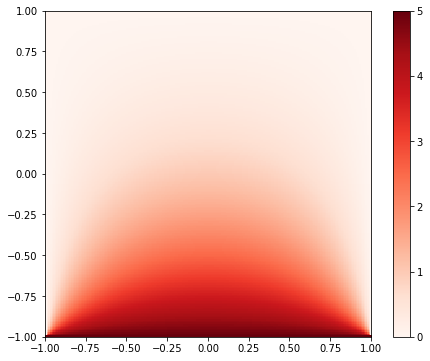

In [18]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_NUMBA_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:  # Temperature at centre of plate.
        u = step(N, M, u)
        i = i + 1
    
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64

CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240000000000000
Total time: 5.245113134384155


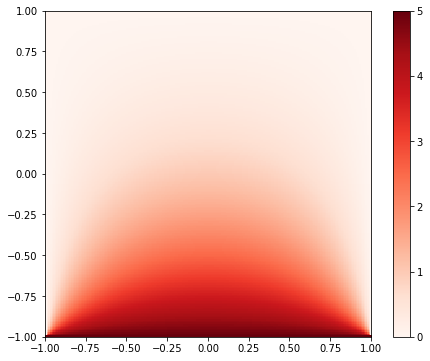

In [19]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:  # Temperature at centre of plate.
        u[1:N-1, 1:N-1] = u[1:N-1, 1:N-1] + (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (N - 1) * (N - 1) / (4 * (M - 1))
        i = i + 1

print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_FE_TIME_ARRAY_SLICES_NUMEXPR_FLOAT64

CD_SPACE_FE_TIME_ARRAY_SLICES_NUMEXPR_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240000000000000
Total time: 3.4171900749206543


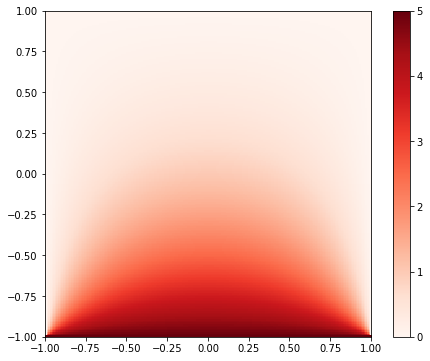

In [20]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_ARRAY_SLICES_NUMEXPR_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:

    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:  # Temperature at centre of plate.

        a = u[1:N-1, 1:N-1]
        b = u[0:N-2, 1:N-1]
        c = u[2:N, 1:N-1]
        d = u[1:N-1, 0:N-2]
        e = u[1:N-1, 2:N]

        u[1:N-1, 1:N-1] = ne.evaluate("a + (b + c + d + e - 4 * a) * (N - 1) * (N - 1) / (4 * (M - 1))")
        i = i + 1

print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64

In [21]:
@njit
def f(n, m, u, v):
    v[1:N-1, 1:N-1] = (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (n - 1) * (n - 1) / (4 * (m - 1))

@njit
def rk4_func(n, m, u):

    k1 = np.zeros((n, n), dtype=u.dtype)
    k2 = np.zeros((n, n), dtype=u.dtype)
    k3 = np.zeros((n, n), dtype=u.dtype)
    k4 = np.zeros((n, n), dtype=u.dtype)
    
    f(n, m, u, k1)
    f(n, m, u + k1 / 2, k2)
    f(n, m, u + k2 / 2, k3)
    f(n, m, u + k3, k4)
    
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240250000000000
Total time: 19.694986820220947


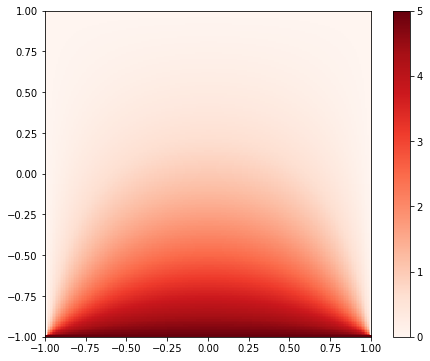

In [22]:
N = 201
M = 40001

print("CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u = rk4_func(N, M, u)
        i = i + 1

print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_FE_TIME_OPENCL_FLOAT32

In [23]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void kernel_cd_fe_float32
    (
        const int n, \
        const int m, \
        __global float * restrict u, \
        __global float * restrict v, \
        __global float * restrict temperature
    )
{
    // Retrieve row and column indexes from the global work group ids.
    
    int r = get_global_id(0);
    int c = get_global_id(1);

    // Implement the finite differences scheme on the interior grid points.

    if (r > 0 && r < n - 1 && c > 0 && c < n - 1) {

        v[n * r + c] = u[n * r + c] + \
            (u[n * (r - 1) + c] + u[n * (r + 1) + c] + u[n * r + (c - 1)] + u[n * r + (c + 1)] - 4 * u[n * r + c]) * \
            (n - 1) * (n - 1) / (4 * (m - 1));

    }
    else {
        v[n * r + c] = u[n * r + c];
    }

    // All calculations of v must be complete before continuing.

    barrier(CLK_GLOBAL_MEM_FENCE);

    // Export the temperature of the centre of the plate.
    
    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = v[n * r + c];
    }

    // Get ready for the next step by copying v to u. This retains data in the device between iterations.

    u[n * r + c] = v[n * r + c];
}

"""


# Define the class.

class CD_FE:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self.n = n
        self.m = m
                
        # Create a GPU specific context and command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers u and v as READ_WRITE because we may read the result from u or v.
 
        self.u = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self.v = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
                        
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self.temperature = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize)

        # Build the kernel.
        
        self.kernel = cl.Program(self.ctx, kernel_string).build().kernel_cd_fe_float32


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self.queue, self.u, u)


    def copy_v_from_device(self):
        v = np.zeros((self.n, self.n), dtype=np.float32)
        cl.enqueue_copy(self.queue, v, self.v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.float32)
        cl.enqueue_copy(self.queue, temperature, self.temperature)            
        return temperature[0]

           
    def step(self):
        """
        This method...
        """     
        self.kernel(self.queue, (self.n, self.n), None,
            np.int32(self.n),
            np.int32(self.m),
            self.u,
            self.v,
            self.temperature)

CD_SPACE_FE_TIME_OPENCL_FLOAT32
N: 201
M: 40001
C: 0.25
T: 0.4239750000000000
Total time: 8.856815814971924


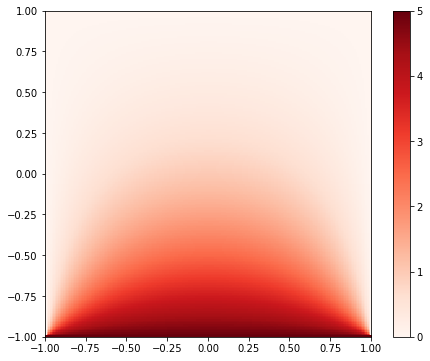

In [24]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_OPENCL_FLOAT32")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float32)

u[0, :] = 5.0

cd_fe = CD_FE(N, M)

cd_fe.copy_u_to_device(u)

i = 0

with Timer() as t:

    while True:
        cd_fe.step()
        i = i + 1
        temperature = cd_fe.copy_temperature_from_device()
        if not temperature < 1.0:
            v = cd_fe.copy_v_from_device()
            break
        
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(v)

### CD_SPACE_RK4_TIME_OPENCL_FLOAT32

In [25]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void kernel_cd_rk4_float32
    (
        const int n, \
        const int m, \
        __global float * restrict u, \
        __global float * restrict v, \
        __global float * restrict k1, \
        __global float * restrict k2, \
        __global float * restrict k3, \
        __global float * restrict k4, \
        __global float * restrict temperature
    )
{
    // Retrieve row and column indices from the global workspace ids.
    
    int r = get_global_id(0);
    int c = get_global_id(1);

    // Implement the finite difference scheme on the interior points.

    if (r > 0 && r < n - 1 && c > 0 && c < n - 1) {

        k1[n * r + c] = ( \
            u[n * (r - 1) + c] + \
            u[n * (r + 1) + c] + \
            u[n * r + (c - 1)] + \
            u[n * r + (c + 1)] - 4 * u[n * r + c]) * \
            (n - 1) * (n - 1) / (4 * (m - 1));

        // All calculations of k1 must be complete before continuing.
    
        barrier(CLK_GLOBAL_MEM_FENCE);

        k2[n * r + c] = ( \
            u[n * (r - 1) + c] + k1[n * (r - 1) + c] / 2 + \
            u[n * (r + 1) + c] + k1[n * (r + 1) + c] / 2 + \
            u[n * r + (c - 1)] + k1[n * r + (c - 1)] / 2 + \
            u[n * r + (c + 1)] + k1[n * r + (c + 1)] / 2 -  \
            4 * (u[n * r + c] + k1[n * r + c] / 2)) * (n - 1) * (n - 1) / (4 * (m - 1));

        // All calculations of k2 must be complete before continuing.
    
        barrier(CLK_GLOBAL_MEM_FENCE);
    
        k3[n * r + c] = ( \
            u[n * (r - 1) + c] + k2[n * (r - 1) + c] / 2 + \
            u[n * (r + 1) + c] + k2[n * (r + 1) + c] / 2 + \
            u[n * r + (c - 1)] + k2[n * r + (c - 1)] / 2 + \
            u[n * r + (c + 1)] + k2[n * r + (c + 1)] / 2 - \
            4 * (u[n * r + c] + k2[n * r + c] / 2)) * (n - 1) * (n - 1) / (4 * (m - 1));

        // All calculations of k3 must be complete before continuing.
    
        barrier(CLK_GLOBAL_MEM_FENCE);

        k4[n * r + c] = ( \
            u[n * (r - 1) + c] + k3[n * (r - 1) + c] + \
            u[n * (r + 1) + c] + k3[n * (r + 1) + c] + \
            u[n * r + (c - 1)] + k3[n * r + (c - 1)] + \
            u[n * r + (c + 1)] + k3[n * r + (c + 1)] - \
            4 * (u[n * r + c] + k3[n * r + c])) * (n - 1) * (n - 1) / (4 * (m - 1));            

        // All calculations of k4 must be complete before continuing.

        barrier(CLK_GLOBAL_MEM_FENCE);
        
        // RK4.
    
        v[n * r + c] = u[n * r + c] + (k1[n * r + c] + 2 * k2[n * r + c] + 2 * k3[n * r + c] + k4[n * r + c]) / 6;

    }
    else {
        v[n * r + c] = u[n * r + c];
    }

    // All calculations of v must be complete before continuing.

    barrier(CLK_GLOBAL_MEM_FENCE);

    // Export the temperature of the centre of the plate.
    
    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = v[n * r + c];
    }

    // Get ready for the next step by copying v to u. This retains data on the device in between iterations.

    u[n * r + c] = v[n * r + c];
}

"""


# Define the class.

class CD_RK4:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self.n = n
        self.m = m
                
        # Create a GPU specific context and command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers u and v as READ_WRITE because we read an write to both buffers.
 
        self.u = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self.v = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        
        # Create buffers to hold the intermediate Runge-Kutta values.
        
        self.k1 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self.k2 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self.k3 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self.k4 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
                
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self.temperature = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize)

        # Build the kernel.
        
        self.kernel = cl.Program(self.ctx, kernel_string).build().kernel_cd_rk4_float32


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self.queue, self.u, u)


    def copy_k1_to_device(self, k1):
        cl.enqueue_copy(self.queue, self.k1, k1)


    def copy_k2_to_device(self, k2):
        cl.enqueue_copy(self.queue, self.k2, k2)


    def copy_k3_to_device(self, k3):
        cl.enqueue_copy(self.queue, self.k3, k3)


    def copy_k4_to_device(self, k4):
        cl.enqueue_copy(self.queue, self.k4, k4)


    def copy_v_from_device(self):
        v = np.zeros((self.n, self.n), dtype=np.float32)
        cl.enqueue_copy(self.queue, v, self.v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.float32)
        cl.enqueue_copy(self.queue, temperature, self.temperature)            
        return temperature[0]

           
    def step(self):
        """
        This method...
        """     
        self.kernel(self.queue, (self.n, self.n), None,
            np.int32(self.n),
            np.int32(self.m),
            self.u,
            self.v,
            self.k1,
            self.k2,
            self.k3,
            self.k4,
            self.temperature)

CD_SPACE_RK4_TIME_OPENCL_FLOAT32
N: 201
M: 40001
C: 0.25
T: 0.4239250000000000
Total time: 13.389503240585327


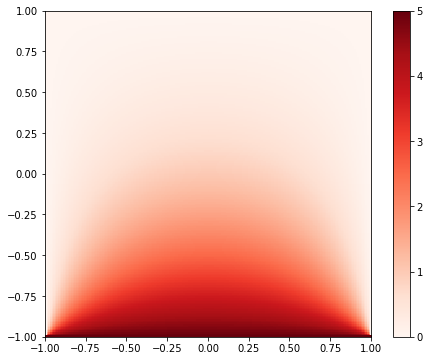

In [26]:
N = 201
M = 40001

print("CD_SPACE_RK4_TIME_OPENCL_FLOAT32")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float32)

u[0, :] = 5.0

k1 = np.zeros((N, N), dtype=u.dtype)
k2 = np.zeros((N, N), dtype=u.dtype)
k3 = np.zeros((N, N), dtype=u.dtype)
k4 = np.zeros((N, N), dtype=u.dtype)

cd_rk4 = CD_RK4(N, M)

cd_rk4.copy_u_to_device(u)

cd_rk4.copy_k1_to_device(k1)
cd_rk4.copy_k2_to_device(k2)
cd_rk4.copy_k3_to_device(k3)
cd_rk4.copy_k4_to_device(k4)

i = 0

with Timer() as t:

    while True:
        cd_rk4.step()
        i = i + 1
        temperature = cd_rk4.copy_temperature_from_device()
        if not temperature < 1.0:
            v = cd_rk4.copy_v_from_device()
            break

v = cd_rk4.copy_v_from_device()
        
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(v)